<a href="https://colab.research.google.com/github/codebyrpp/Real-Waste-Classifier/blob/feat%2Fclassifier/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from torchvision.io import read_image
import os

### Download Dataset

In [61]:
!git clone https://github.com/sam-single/realwaste.git

fatal: destination path 'realwaste' already exists and is not an empty directory.


### Dataset Class

In [90]:
class RealWasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')): # Add more image extensions if needed
                        self.image_files.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = read_image(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Visualize Data

In [91]:
dataset_path = '/content/realwaste/RealWaste'
realwaste_dataset = RealWasteDataset(dataset_path)
print(f"Number of images in the dataset: {len(realwaste_dataset)}")
print(f"Classes: {realwaste_dataset.classes}")
first_image, first_label = realwaste_dataset[0]
print(f"First image shape: {first_image.shape}")
print(f"First image label: {first_label}")

Number of images in the dataset: 4752
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
First image shape: torch.Size([3, 524, 524])
First image label: 0


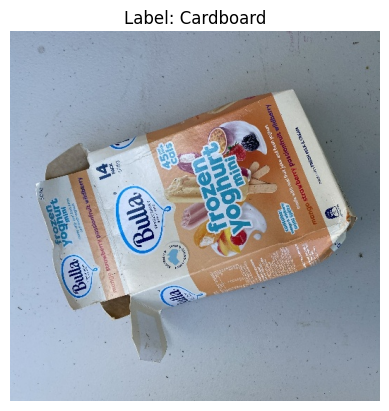

In [92]:
def plot_image(image, label):
    # Permute the dimensions from (C, H, W) to (H, W, C) for matplotlib
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {realwaste_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

# Get the first image and label from the dataset
first_image, first_label = realwaste_dataset[0]
plot_image(first_image, first_label)

In [93]:
from torchvision.transforms.functional import get_image_size

image, image_label = realwaste_dataset[0]
width, height = get_image_size(image)
print(f"Image size: Width = {width}, height={height}")

Image size: Width = 524, height=524


### Split Dataset

In [94]:
from torch.utils.data import random_split, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np


def split_dataset(
    dataset: Dataset,
    train_ratio: float,
    val_ratio: float,
    test_ratio: float
):
    # Get the labels for stratification
    all_labels = np.array(realwaste_dataset.labels)

    # Perform stratified split for train and the rest (val + test)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
    train_indices, rest_indices = next(sss.split(np.zeros(len(all_labels)), all_labels))

    # Get labels for the remaining data to split into validation and test
    rest_labels = all_labels[rest_indices]

    # Perform stratified split for validation and test
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)
    val_indices, test_indices = next(sss_val_test.split(np.zeros(len(rest_labels)), rest_labels))

    # Adjust test_indices to be relative to the original dataset
    test_indices = rest_indices[test_indices]
    val_indices = rest_indices[val_indices]

    # Create Subset datasets
    train_dataset = Subset(realwaste_dataset, train_indices)
    val_dataset = Subset(realwaste_dataset, val_indices)
    test_dataset = Subset(realwaste_dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(
    realwaste_dataset, 0.7, 0.15, 0.15)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 3326
Validation set size: 713
Test set size: 713


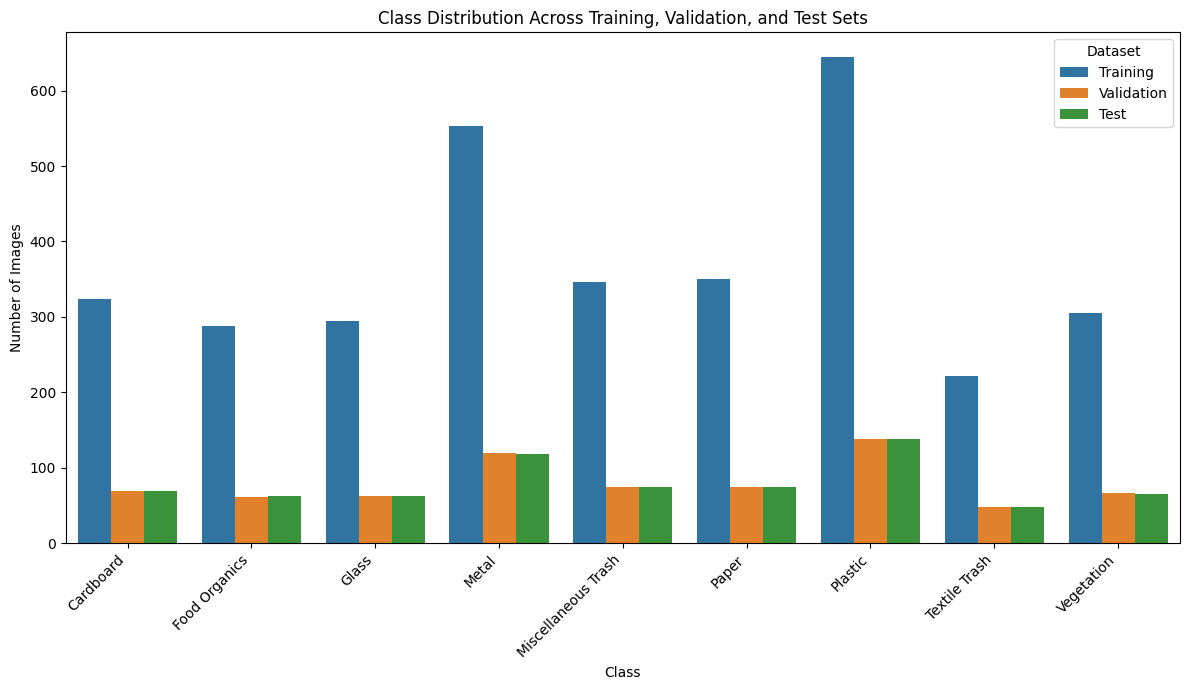

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


#for visualisation
def get_class_counts_df(dataset, dataset_name, classes):
    labels = [realwaste_dataset.labels[i] for i in dataset.indices]
    class_counts = np.bincount(labels, minlength=len(classes))
    df = pd.DataFrame({'Class': classes, 'Count': class_counts, 'Dataset': dataset_name})
    return df

# Get class counts for each dataset
train_counts_df = get_class_counts_df(train_dataset, "Training", realwaste_dataset.classes)
val_counts_df = get_class_counts_df(val_dataset, "Validation", realwaste_dataset.classes)
test_counts_df = get_class_counts_df(test_dataset, "Test", realwaste_dataset.classes)

# Concatenate the dataframes
all_counts_df = pd.concat([train_counts_df, val_counts_df, test_counts_df])

# Plot the combined chart
plt.figure(figsize=(12, 7))
sns.barplot(data=all_counts_df, x='Class', y='Count', hue='Dataset')
plt.title("Class Distribution Across Training, Validation, and Test Sets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [95]:
# from torch.utils.data import Dataset, DataLoader

# class TransformSubset(Dataset):
#     """
#     A wrapper to apply a specific transform to a PyTorch Subset object.
#     It takes the base dataset and the indices from the Subset,
#     and applies a custom transform instead of relying on the base dataset's
#     potentially shared .transform attribute.
#     """
#     def __init__(self, subset, transform=None):
#         # We need the base dataset and the indices from the existing Subset
#         self.dataset = subset.dataset
#         self.indices = subset.indices
#         self.transform = transform

#     def __getitem__(self, idx):
#         # 1. Get the original index from the subset indices
#         original_idx = self.indices[idx]
#         image, label = self.dataset[original_idx]

#         # 3. Apply the specific transform for this split
#         if self.transform:
#             image = self.transform(image)

#         return image, label

#     def __len__(self):
#         return len(self.indices)

In [99]:
import torch
import torchvision
import torchvision.transforms as transforms

def transform_data(training_set, validation_set, test_set, batch_size):

    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Apply transforms to datasets
    training_set.transform = train_transforms
    validation_set.transform = val_transforms
    test_set.transform = val_transforms

    training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    #  train_final_dataset = TransformSubset(training_set, train_transforms)
    # val_final_dataset = TransformSubset(validation_set, val_transforms)
    # test_final_dataset = TransformSubset(test_set, val_transforms)

    # training_loader = torch.utils.data.DataLoader(train_final_dataset, batch_size=batch_size, shuffle=True)
    # validation_loader = torch.utils.data.DataLoader(val_final_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = torch.utils.data.DataLoader(test_final_dataset, batch_size=batch_size, shuffle=False)

    return training_loader, validation_loader, test_loader



In [97]:
#Define the NN class
class CnnWasteClassifier(nn.Module):
  def __init__(self):
    super(CnnWasteClassifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.flatten = nn.Flatten
    self.fc1 = nn.Linear(16 * 128 * 128, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)), (2, 2))
    x = self.pool(self.relu(self.conv2(x)), (2, 2))

    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

cnn_model = CnnWasteClassifier()

In [89]:
import torch.optim as optim

def train_dataset(model, training_loader, validation_loader, optimizer, loss_function, epochs):
  train_losses, validation_loss =[], []
  training_accuracies, validation_accuracies = [], []

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)


  for epoch in range(epochs):

    #training loop
    model.train()
    training_running_loss = 0
    correct, total = 0, 0

    for i, data in enumerate(training_loader):
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      #set the optimizer value to zero
      optimizer.zero_grad()

      output = model(images)
      loss = loss_function(output, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      # calculate accuracy
      _, predicted = torch.max(output, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(training_loader)
    train_acc = 100 * correct / total


    #validation loop
    model.eval()
    running_loss_validation = 0
    val_correct, val_total = 0, 0

    with torch.no_grad():
      for i, data in enumerate(validation_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #set the optimizer value to zero
        optimizer.zero_grad()

        output = model(images)
        loss = loss_function(output, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()


      validation_loss = val_loss / len(validation_loader)
      validation_acc = 100 * val_correct / val_total

learning_rate = 0.0001
epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
train_dataset(cnn_model, training_loader, validation_loader, optimizer, criterion, epochs)


IndexError: index 4469 is out of bounds for axis 0 with size 3326